# Step3 统计主题与数据可视化

    分析每类新闻中，大家最关心的主题。
    步骤包括：
        读取数据 --> 分析数据 --> 作图
    这里分析数据有一个考量：
        搜狐新闻的评论数和浏览数较少，大多为0，没有采集的意义，不足以当做权重。
        新闻的内容，如上节所述，包含大量的常用词，统计词频，价值不大。
        新闻的标题，包含大量的主题词，可以用来作为关键词，但是仍然存在常用词。
         这里的一个处理方法是：使用停用词表做过滤，然后手动补充一些常用词，随着经常的迭代可以做到提取主题词。
         而且包含标题的情况下，没有必要使用模型再次提取主题。
        新闻的出版社：在一定程度上有意义，也可以作图体现。

# 1. 导入所需库

In [1]:
# -*- coding: utf-8 -*-
import jieba
import numpy as np
import codecs
import pandas as pd
import codecs
import matplotlib.pyplot as plt
%matplotlib inline

# 2. 读取数据

    纯粹的代码复用。

In [3]:
import json

def readfromJson(filename):
    dir = "data/"
    filename = dir + filename
    file = codecs.open(filename, 'r', encoding='utf-8')
    
    data = {}
    data['title'] = []
    data['publisher'] = []
    data['type'] = []
    data['time'] = []
    data['content'] = []
    
    for line in file.readlines():
        news_unit = json.loads(line)
        data['title'].append(news_unit['title'])
        data['publisher'].append(news_unit['publisher'])
        data['type'].append(news_unit['type'])
        data['time'].append(news_unit['time'])
        data['content'].append(news_unit['content'])

    data = pd.DataFrame(data)
    return data

GuojiData = readfromJson("Guoji.json")
GuoneiData = readfromJson("Guonei.json")
ShehuiData = readfromJson("Shehui.json")

# 3. 提取热词，统计频率

    如标题所述，没啥好说的。

In [4]:
#主题词主要集中在标题中。这里以词频做热词
def getTopWords(data):
    data["segment"] = data["content"].apply(lambda x : list(jieba.cut(x)))
    tmp = list(data["segment"])
    segments = []
    for content in tmp:
        segments.extend(content)
    data = data.drop(['segment'], axis=1)
    words_df = pd.DataFrame({'segment' : segments})
    words_df = words_df.dropna()

    stopwords = pd.read_csv("stopwords.txt", index_col=False, quoting=3, sep="\t", names=['stopword'], encoding = "utf-8")
    words_df = words_df[~words_df.segment.isin(stopwords.stopword)]
    words_df = words_df[~words_df.segment.isin(['\n', '\r', ' '])]
    words_stat = words_df.groupby(by = ['segment'])['segment'].agg({"计数" : np.size})
    words_stat = words_stat.reset_index().sort(columns = "计数",ascending = False)
    return words_stat.iloc[:20]

Guoji = getTopWords(GuojiData)
Guonei = getTopWords(GuoneiData)
Shehui = getTopWords(ShehuiData)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 0.325 seconds.
DEBUG:jieba:Loading model cost 0.325 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.
/opt/ds/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# 4. 做频率图

    即包括三类新闻各自的频率直方图。

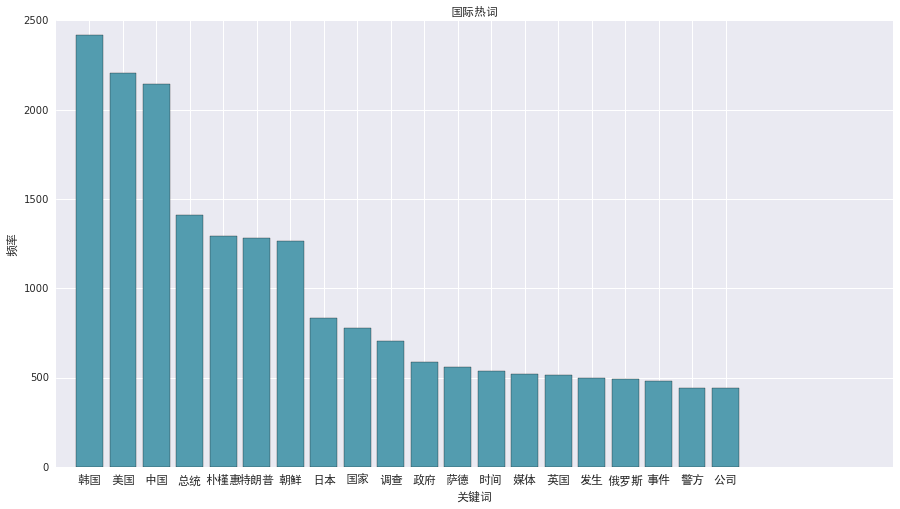

In [7]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

myfont = mpl.font_manager.FontProperties(fname='simhei.ttf') 

x = Guoji.segment
y = Guoji["计数"]
_, ax = plt.subplots(figsize = (15, 8))
x_data = np.arange(1, 21)
ax.bar(x_data, y, color = '#539caf', width = 0.8, align = 'center')
ax.set_xticks(x_data)
ax.set_xticklabels(x, fontproperties = myfont, size='medium')
ax.set_xlabel(u"关键词", fontproperties = myfont, size='medium')
ax.set_ylabel(u"频率", fontproperties = myfont, size='medium')
ax.set_title(u"国际热词", fontproperties = myfont, size='medium')

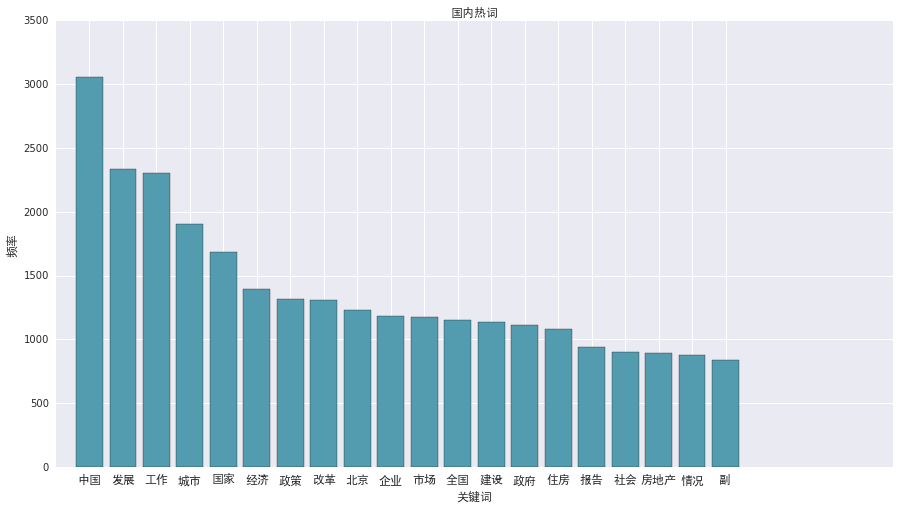

In [8]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

myfont = mpl.font_manager.FontProperties(fname='simhei.ttf') 

x = Guonei.segment
y = Guonei["计数"]
_, ax = plt.subplots(figsize = (15, 8))
x_data = np.arange(1, 21)
ax.bar(x_data, y, color = '#539caf', width = 0.8, align = 'center')
ax.set_xticks(x_data)
ax.set_xticklabels(x, fontproperties = myfont, size='medium')
ax.set_xlabel(u"关键词", fontproperties = myfont, size='medium')
ax.set_ylabel(u"频率", fontproperties = myfont, size='medium')
ax.set_title(u"国内热词", fontproperties = myfont, size='medium')

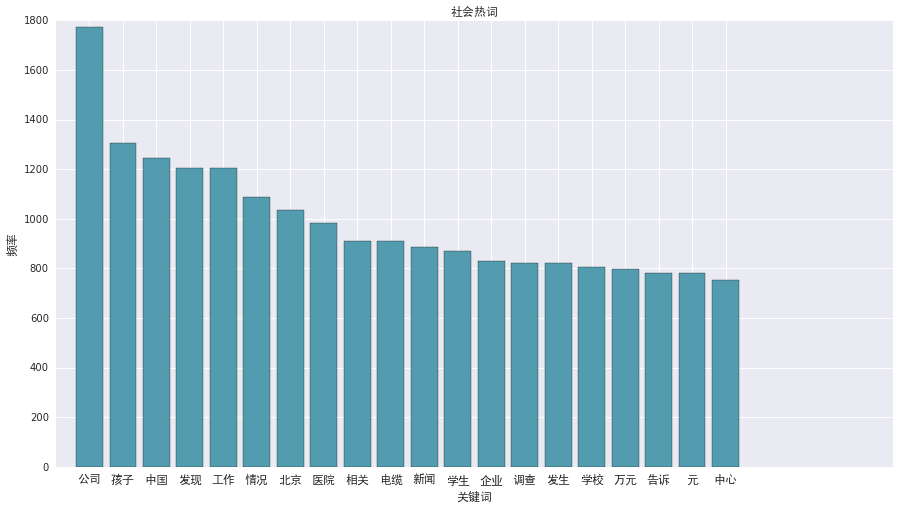

In [9]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

myfont = mpl.font_manager.FontProperties(fname='simhei.ttf') 

x = Shehui.segment
y = Shehui["计数"]
_, ax = plt.subplots(figsize = (15, 8))
x_data = np.arange(1, 21)
ax.bar(x_data, y, color = '#539caf', width = 0.8, align = 'center')
ax.set_xticks(x_data)
ax.set_xticklabels(x, fontproperties = myfont, size='medium')
ax.set_xlabel(u"关键词", fontproperties = myfont, size='medium')
ax.set_ylabel(u"频率", fontproperties = myfont, size='medium')
ax.set_title(u"社会热词", fontproperties = myfont, size='medium')

# 5. Extra看看出版社的分布

    尽管没啥用，但是还是拉出来看看

In [115]:
frames = [GuojiData, GuoneiData, ShehuiData]
data = pd.concat(frames)
pubdata = data['publisher'].groupby(data['publisher']).agg({"count" : np.size})
pubdata = pubdata.reset_index().sort(columns = "count",ascending = False)
pubdata = pubdata.iloc[:20]

/opt/ds/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,count
count,20.000000
mean,174.500000
std,216.258739
min,22.000000
25%,40.750000
50%,63.500000
75%,251.500000
max,736.000000


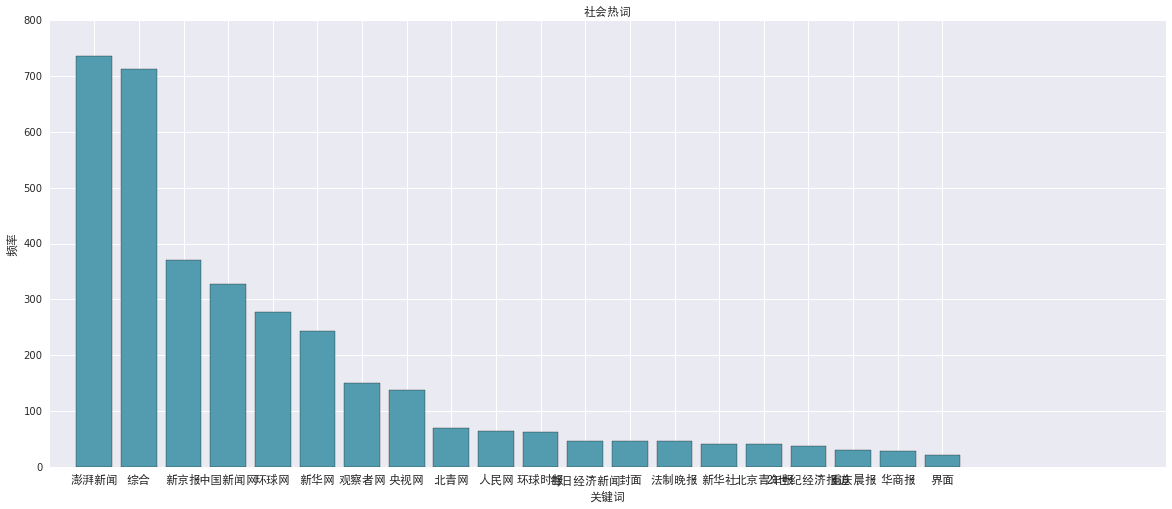

In [124]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

myfont = mpl.font_manager.FontProperties(fname='simhei.ttf') 

x = pubdata['publisher'].values
y = pubdata['count'].values
_, ax = plt.subplots(figsize = (20, 8))
x_data = np.arange(1, 21)
ax.bar(x_data, y, color = '#539caf', width = 0.8, align = 'center')
ax.set_xticks(x_data)
ax.set_xticklabels(x, fontproperties = myfont, size='medium')
ax.set_xlabel(u"关键词", fontproperties = myfont, size='medium')
ax.set_ylabel(u"频率", fontproperties = myfont, size='medium')
ax.set_title(u"社会热词", fontproperties = myfont, size='medium')